<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/sentiment_analysis_with_pretrained_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 10.1 MB/s eta 0:00:00


In [ ]:
 pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 18.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=16eae8d218f1779de30b111a145defa6b689f36981cead535bf93b1c29276ccd
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [ ]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [ ]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

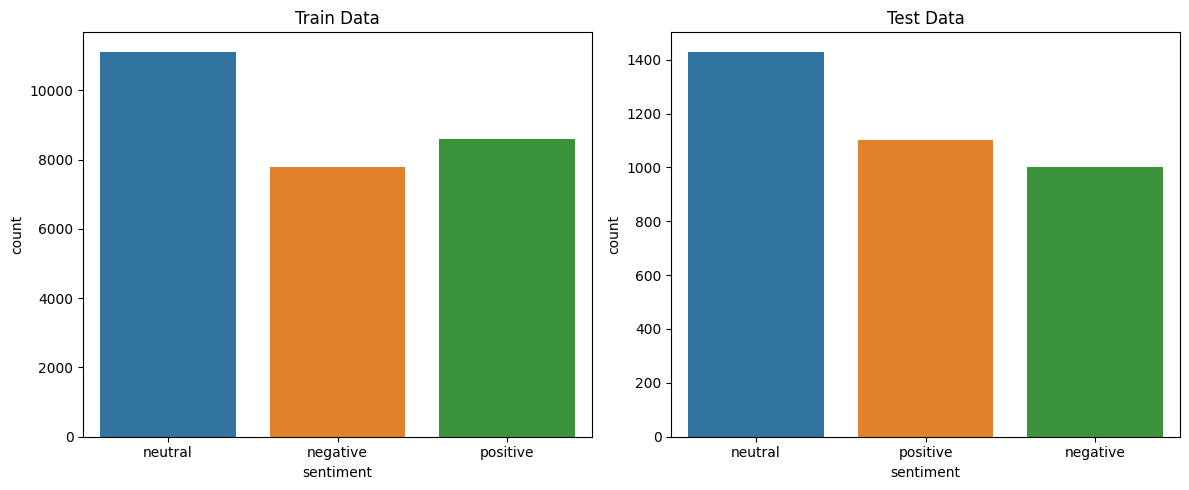

In [ ]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
neagtive → -1
neutral → 0
postive → 1

In [ ]:
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)

In [ ]:
train['label'].value_counts(normalize=True) # got same ratio before converting

 0    0.404549
 1    0.312300
-1    0.283151
Name: label, dtype: float64

In [ ]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

In [ ]:
#convert label to one-hot-coding
y_train = pd.get_dummies(y_train, columns = ['label'])
y_test = pd.get_dummies(y_test, columns = ['label'])

## From here I will use transformer library from Hugging-face.
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
X_train.iloc[:20,]

0                   I`d have responded, if I were going
1         Sooo SAD I will miss you here in San Diego!!!
2                             my boss is bullying me...
3                        what interview! leave me alone
4      Sons of ****, why couldn`t they put them on t...
5     http://www.dothebouncy.com/smf - some shameles...
6     2am feedings for the baby are fun when he is a...
7                                            Soooo high
8                                           Both of you
9      Journey!? Wow... u just became cooler.  hehe....
10     as much as i love to be hopeful, i reckon the...
11    I really really like the song Love Story by Ta...
12         My Sharpie is running DANGERously low on ink
13    i want to go to music tonight but i lost my vo...
14                           test test from the LG enV2
15                                Uh oh, I am sunburned
16     S`ok, trying to plot alternatives as we speak...
17    i`ve been sick for the past few days  and 

In [ ]:
# Print sentence 0
print('Original: ', X_train[0])
print('Processed: ', text_preprocessing(X_train[0]))

Original:   I`d have responded, if I were going
Processed:  I`d have responded, if I were going


In [ ]:
#The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
#同じlengthで読み込むために不用意に伸ばされた部分は無視してねっていうこと

In [ ]:
#I can use pre_trained bert model from transformers library in hugging-face
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
train

,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1
...,...,...
27476,wish we could come see u on Denver husband l...,-1
27477,I`ve wondered about rake to. The client has ...,-1
27478,Yay good for both of you. Enjoy the break - y...,1
27479,But it was worth it ****.,1


In [ ]:
train

,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1
...,...,...
27476,wish we could come see u on Denver husband l...,-1
27477,I`ve wondered about rake to. The client has ...,-1
27478,Yay good for both of you. Enjoy the break - y...,1
27479,But it was worth it ****.,1


In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([train.text.values, test.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  110
